In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['image.cmap'] = 'viridis'
plt.style.use('ggplot')

In [2]:
data = {
    'hopg_down': {
        'file': './raw/HOPG-DOWN.txt',
        'dim': np.linspace(0, 2, 100),
    },
    'hopg_up': {
        'file': './raw/HOPG-UP.txt',
        'dim': np.linspace(0, 2, 100),
    },
    'au_1': {
        'file': './raw/AU-1-1.txt',
        'dim': np.linspace(0, 300, 512),
    },
    'au_2': {
        'file': './raw/AU-2-2.txt',
        'dim': np.linspace(0, 300, 512),
    },
}

In [3]:
for name, obj in data.items():
    im_data = np.genfromtxt(obj['file'])
    im_data = np.flipud(im_data)
    obj['data'] = im_data

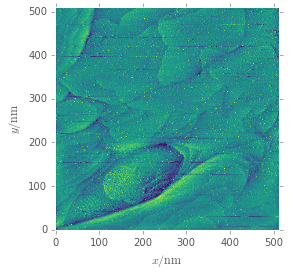

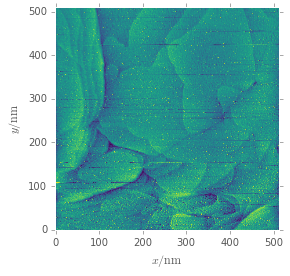

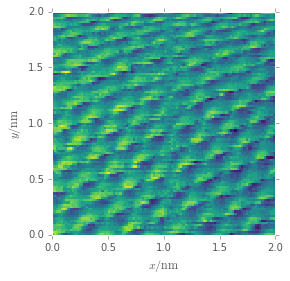

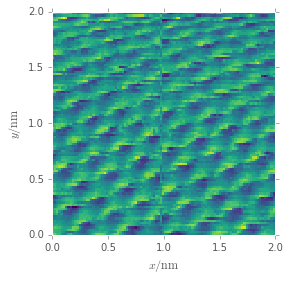

In [4]:
for name, obj in data.items():
    ax = plt.subplot(111, aspect='equal')
    if(obj['dim'].size > 200):
        plt.imshow(obj['data'], origin='lower')
        plt.grid(b=False)
    else:
        plt.pcolormesh(obj['dim'], obj['dim'], obj['data'])
    plt.xlabel(r'$x / \mathrm{nm}$')
    plt.ylabel(r'$y / \mathrm{nm}$')
    plt.savefig('build/plots/{}.pdf'.format(name))
    plt.show()
    plt.clf()